In [1]:
from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [2]:
# GLOBAL SETTINGS

# Data directories

#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
model_dataDir = 'DATA/MODELDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/STATINFER/'
model_plot_dataDir = 'DATA/MODELRESULTS/'

# Time periods settings
YEAR = 365

# Helpers
sns.set_style('darkgrid')
idx = pd.IndexSlice

# END GLOBAL SETTINGS

In [3]:
# HELPER FUNCTIONS

# Prediction vs Actual Scatter Plot
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

# Daily Information Coefficient(IC) Distribution
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

# Rolling Daily IC
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()   
# END HELPER FUNCTIONS

In [4]:
# Read in MDF with features
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)

# Filter out 60 and 90d columns
# Reason: Due to the relativly small size of the dataset, all the NaN values leave me with just 3 months of usable data.
# I could impute the NaNs but for such long time periods, I think this is too risky and could lead to false models
#ninety_day_filter = model_mdf.filter(like='90d')
#model_mdf = model_mdf.drop(ninety_day_filter.columns, axis=1)
#sixty_day_filter = model_mdf.filter(like='60d')
#model_mdf = model_mdf.drop(sixty_day_filter.columns, axis=1)

# Impute missing entries in the remaining data (max 30d period seems reasonable)
#model_mdf = model_mdf.groupby('Coin').apply(lambda x: x.fillna(x.mean()))

In [5]:
# Drop NaNs, OHLCV columns and lag period columns
data = model_mdf

# Drop OHLCV
data = (model_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))

# Drop Features
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data = data.drop([c for c in data.columns if 'year' in c], axis=1)
data = data.drop([c for c in data.columns if 'month' in c], axis=1)
data = data.drop([c for c in data.columns if 'Principal' in c], axis=1)




data = data.swaplevel().sort_index()

In [6]:
data

Volume        RSI     BB_high  \
Coin                  Dates                                             
basic-attention-token 2019-06-30  5.173653e+07  48.030313    0.358050   
                      2019-07-01  6.789552e+07  49.910979    0.357641   
                      2019-07-02  6.595751e+07  44.761214    0.356710   
                      2019-07-03  4.781655e+07  43.525319    0.356490   
                      2019-07-04  3.859085e+07  43.194110    0.356381   
...                                        ...        ...         ...   
zcash                 2022-01-03  1.594986e+08  40.227259  171.251488   
                      2022-01-04  2.048720e+08  40.154175  171.254197   
                      2022-01-05  2.168991e+08  31.743784  173.722292   
                      2022-01-06  2.872861e+08  31.274906  175.465363   
                      2022-01-07  3.715053e+08  40.045194  174.932196   

                                      BB_low       ATR      MACD     STOCH  \
Coin                  Dates                                                  
basic-attention-token 2019-06-30    0.289922 -0.407368 -0.364681  0.540733   
                      2019-07-01    0.289788 -0.396859 -0.327434  0.653160   
                      2019-07-02    0.288583 -0.373908 -0.323117  0.875320   
                      2019-07-03    0.287174 -0.397699 -0.324431  1.026579   
                      2019-07-04    0.285850 -0.412238 -0.324992  1.132719   
...                                      ...       ...       ...       ...   
zcash                 2022-01-03  145.158369  0.427745 -1.000571  0.959851   
                      2022-01-04  144.277024  0.401068 -0.979570  0.954600   
                      2022-01-05  139.968837  0.483645 -1.114765  1.429570   
                      2022-01-06  135.848785  0.460576 -1.219341  1.755128   
                      2022-01-07  134.396258  0.458249 -1.188791  1.003589   

                                        ADX    DI_PLUS   DI_MINUS  return_1d  \
Coin                  Dates                                                    
basic-attention-token 2019-06-30  14.541276  19.103882  21.134786   0.011440   
                      2019-07-01  14.271231  23.908434  19.262921   0.014835   
                      2019-07-02  13.332608  21.340458  21.828486  -0.043155   
                      2019-07-03  12.461029  20.645390  21.117523  -0.011525   
                      2019-07-04  12.279248  19.673856  24.005101  -0.003007   
...                                     ...        ...        ...        ...   
zcash                 2022-01-03  22.229177  16.796249  29.153791  -0.012069   
                      2022-01-04  22.117534  18.122443  27.564103  -0.000792   
                      2022-01-05  23.113478  15.930480  33.899572  -0.107334   
                      2022-01-06  24.258728  15.016328  34.336451  -0.007992   
                      2022-01-07  24.735652  16.843394  31.932555   0.074085   

                                  return_7d  return_14d  return_30d  \
Coin                  Dates                                           
basic-attention-token 2019-06-30  -0.004612   -0.004056   -0.002786   
                      2019-07-01   0.002256   -0.003355   -0.003249   
                      2019-07-02  -0.001892   -0.008466   -0.004355   
                      2019-07-03   0.003918   -0.007732   -0.003344   
                      2019-07-04   0.011023   -0.005689   -0.003421   
...                                     ...         ...         ...   
zcash                 2022-01-03  -0.008594   -0.005375   -0.007124   
                      2022-01-04  -0.000455   -0.006460   -0.006133   
                      2022-01-05  -0.016816   -0.014943   -0.009941   
                      2022-01-06  -0.020899   -0.016059   -0.008621   
                      2022-01-07  -0.005248   -0.011096   -0.007018   

                                  target_1d  target_7d  target_14d  target_30d  
Coin                  Dates  

In [7]:
# Create X and Y values for the model
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)

In [8]:
X

Volume        RSI     BB_high  \
Coin                  Dates                                             
basic-attention-token 2019-06-30  5.173653e+07  48.030313    0.358050   
                      2019-07-01  6.789552e+07  49.910979    0.357641   
                      2019-07-02  6.595751e+07  44.761214    0.356710   
                      2019-07-03  4.781655e+07  43.525319    0.356490   
                      2019-07-04  3.859085e+07  43.194110    0.356381   
...                                        ...        ...         ...   
zcash                 2022-01-03  1.594986e+08  40.227259  171.251488   
                      2022-01-04  2.048720e+08  40.154175  171.254197   
                      2022-01-05  2.168991e+08  31.743784  173.722292   
                      2022-01-06  2.872861e+08  31.274906  175.465363   
                      2022-01-07  3.715053e+08  40.045194  174.932196   

                                      BB_low       ATR      MACD     STOCH  \
Coin                  Dates                                                  
basic-attention-token 2019-06-30    0.289922 -0.407368 -0.364681  0.540733   
                      2019-07-01    0.289788 -0.396859 -0.327434  0.653160   
                      2019-07-02    0.288583 -0.373908 -0.323117  0.875320   
                      2019-07-03    0.287174 -0.397699 -0.324431  1.026579   
                      2019-07-04    0.285850 -0.412238 -0.324992  1.132719   
...                                      ...       ...       ...       ...   
zcash                 2022-01-03  145.158369  0.427745 -1.000571  0.959851   
                      2022-01-04  144.277024  0.401068 -0.979570  0.954600   
                      2022-01-05  139.968837  0.483645 -1.114765  1.429570   
                      2022-01-06  135.848785  0.460576 -1.219341  1.755128   
                      2022-01-07  134.396258  0.458249 -1.188791  1.003589   

                                        ADX    DI_PLUS   DI_MINUS  return_1d  \
Coin                  Dates                                                    
basic-attention-token 2019-06-30  14.541276  19.103882  21.134786   0.011440   
                      2019-07-01  14.271231  23.908434  19.262921   0.014835   
                      2019-07-02  13.332608  21.340458  21.828486  -0.043155   
                      2019-07-03  12.461029  20.645390  21.117523  -0.011525   
                      2019-07-04  12.279248  19.673856  24.005101  -0.003007   
...                                     ...        ...        ...        ...   
zcash                 2022-01-03  22.229177  16.796249  29.153791  -0.012069   
                      2022-01-04  22.117534  18.122443  27.564103  -0.000792   
                      2022-01-05  23.113478  15.930480  33.899572  -0.107334   
                      2022-01-06  24.258728  15.016328  34.336451  -0.007992   
                      2022-01-07  24.735652  16.843394  31.932555   0.074085   

                                  return_7d  return_14d  return_30d  
Coin                  Dates                                          
basic-attention-token 2019-06-30  -0.004612   -0.004056   -0.002786  
                      2019-07-01   0.002256   -0.003355   -0.003249  
                      2019-07-02  -0.001892   -0.008466   -0.004355  
                      2019-07-03   0.003918   -0.007732   -0.003344  
                      2019-07-04   0.011023   -0.005689   -0.003421  
...                                     ...         ...         ...  
zcash                 2022-01-03  -0.008594   -0.005375   -0.007124  
                      2022-01-04  -0.000455   -0.006460   -0.006133  
                      2022-01-05  -0.016816   -0.014943   -0.009941  
                      2022-01-06  -0.020899   -0.016059   -0.008621  
                      2022-01-07  -0.005248   -0.011096   -0.007018  

[35914 rows x 14 columns]

In [9]:
# This is a custom implementation of TimeSeriesSplit CV from sklearn for finance data.
# It is taken from code developed by Stefen Jansen and Marcos Lopez de Prado.
# It is meant to eliminate any spill over between several train/test pairs derived from the dataset.
# Financial data is especially suseptible to such leakage and so a custom TimeSeries CV approach is necessary.
# The class below creates several train/test split pairs from the dataset and spearates them using
# purging, embargoing, and Combinatorial CV techniques.

class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'Coin' and 'Dates'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Dates').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Dates']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Dates > days[train_start])
                              & (dates.Dates <= days[train_end])].index
            test_idx = dates[(dates.Dates > days[test_start])
                             & (dates.Dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [10]:
# LINEAR REGRESSION MODELING

# Cross Validation
train_period_length = 30
test_period_length = 7
n_splits = int(2 * YEAR / test_period_length)
lookahead = 7

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [11]:
# Train the model and make predictions
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()

try:
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
       
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        


        lr.fit(X=X_train, y=y_train)
        y_pred = lr.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='Dates')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        lr_scores.append(scores)
        lr_predictions.append(preds)


except IndexError:
    print('Ran out of data to make more train/test splits')


lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

In [12]:
lr_predictions

actuals  predicted
Coin                  Dates                          
basic-attention-token 2022-01-01 -0.026773  -0.013743
                      2022-01-02 -0.032627  -0.014585
                      2022-01-03 -0.028826  -0.010550
                      2022-01-04 -0.030189  -0.013711
                      2022-01-05 -0.006160  -0.006304
...                                    ...        ...
zcash                 2020-01-13  0.038911   0.008416
                      2020-01-14  0.003972   0.011866
                      2020-01-15  0.006720   0.007909
                      2020-01-16 -0.010217   0.006203
                      2020-01-17 -0.026472   0.008450

[28392 rows x 2 columns]

In [13]:
# Save results
lr_scores.to_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions.to_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')
# Re-load results
lr_scores = pd.read_hdf(f'{model_dataDir}lr_model_scores.h5', 'lr/scores')
lr_predictions = pd.read_hdf(f'{model_dataDir}lr_model_predictions.h5', 'lr/predictions')

In [14]:
# Evaluation
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

Information Coefficient (overall): 5.979% (p-value: 0.0000%)


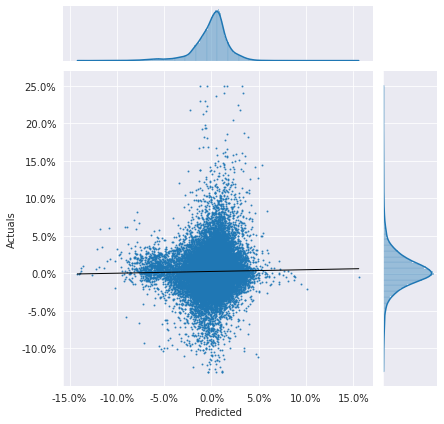

In [15]:
plot_preds_scatter(lr_predictions)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


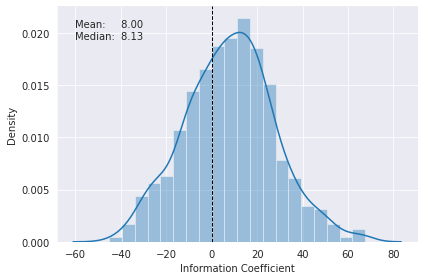

In [16]:
plot_ic_distribution(lr_scores)

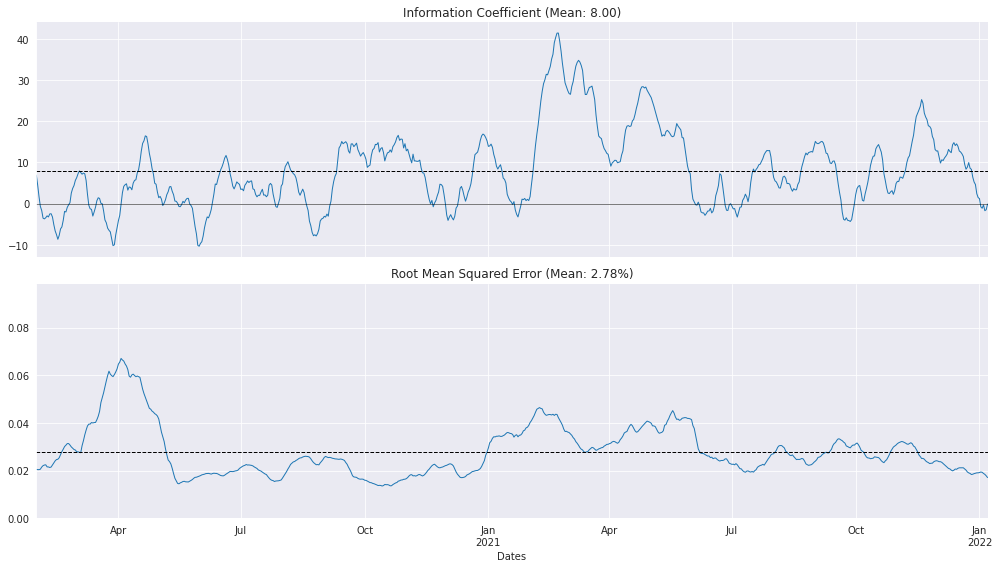

In [17]:
plot_rolling_ic(lr_scores)

In [18]:
# With Ridge Regression
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [19]:
n_splits = int(2 * YEAR/test_period_length)
train_period_length = 30
test_period_length = 7
lookahead = 7

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [20]:
target = f'target_{lookahead}d'

In [21]:
# Cross Validation with Ridge
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')], axis=1)

            ridge_scores.append(scores.assign(alpha=alpha))
            ridge_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
            
    except IndexError: 
        print('Ran out of data for train/test splits')
        ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 



In [22]:
ridge_predictions

[                                   actuals  predicted   alpha
 Coin                  Dates                                  
 basic-attention-token 2022-01-01 -0.026773  -0.008614  0.0001
                       2022-01-02 -0.032627  -0.009456  0.0001
                       2022-01-03 -0.028826  -0.005421  0.0001
                       2022-01-04 -0.030189  -0.008582  0.0001
                       2022-01-05 -0.006160  -0.001175  0.0001
 ...                                    ...        ...     ...
 zcash                 2022-01-03 -0.006476   0.000643  0.0001
                       2022-01-04 -0.008246   0.000235  0.0001
                       2022-01-05  0.011734   0.003857  0.0001
                       2022-01-06  0.008534  -0.000174  0.0001
                       2022-01-07 -0.000413  -0.002089  0.0001
 
 [273 rows x 3 columns],
                                    actuals  predicted   alpha
 Coin                  Dates                                  
 basic-attention-token 2021-

In [23]:
ridge_scores

[                   ic      rmse   alpha
 Dates                                  
 2022-01-01  -4.736842  0.020735  0.0001
 2022-01-02 -11.700405  0.021060  0.0001
 2022-01-03   7.024291  0.023023  0.0001
 2022-01-04   5.242915  0.019467  0.0001
 2022-01-05 -11.012146  0.009443  0.0001
 2022-01-06   7.489879  0.011398  0.0001
 2022-01-07  11.659919  0.011475  0.0001,
                    ic      rmse   alpha
 Dates                                  
 2021-12-25  10.748988  0.012300  0.0001
 2021-12-26  19.352227  0.010257  0.0001
 2021-12-27  10.668016  0.013909  0.0001
 2021-12-28   1.943320  0.016891  0.0001
 2021-12-29   5.040486  0.017137  0.0001
 2021-12-30 -14.817814  0.019171  0.0001
 2021-12-31  -4.534413  0.017406  0.0001,
                    ic      rmse   alpha
 Dates                                  
 2021-12-18  -1.396761  0.014869  0.0001
 2021-12-19   6.619433  0.025938  0.0001
 2021-12-20 -14.595142  0.021428  0.0001
 2021-12-21 -25.161943  0.016207  0.0001
 2021-12-22  -

In [24]:
ridge_coeffs

{}

In [25]:
# Save the ridge results
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')

ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')

ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')

#  Reload the data
ridge_scores = pd.read_hdf(f'{model_dataDir}Ridge_Scores.h5', 'ridge/scores')
ridge_coeffs = pd.read_hdf(f'{model_dataDir}Ridge_Coeffs.h5', 'ridge/coeffs')
ridge_predictions = pd.read_hdf(f'{model_dataDir}Ridge_Predictions.h5', 'ridge/predictions')


In [26]:
# Evaluate the Ridge Results 
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')

Information Coefficient (overall): 4.805% (p-value: 0.0000%)


In [27]:
# Ridge Alpha IC scores
ridge_scores.groupby('alpha').ic.describe()

,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,728.0,8.004621,19.792151,-45.121457,-5.384615,8.127530,20.536437,67.510121
0.0005,728.0,8.004788,19.792144,-45.121457,-5.384615,8.127530,20.536437,67.510121
0.0010,728.0,8.004788,19.792144,-45.121457,-5.384615,8.127530,20.536437,67.510121
0.0050,728.0,8.002508,19.795204,-45.121457,-5.384615,8.127530,20.536437,67.510121
0.0100,728.0,8.004121,19.794627,-45.121457,-5.384615,8.127530,20.536437,67.510121
0.0500,728.0,7.992275,19.787899,-45.121457,-5.399798,8.026316,20.460526,67.510121
0.1000,728.0,7.986964,19.797428,-45.121457,-5.399798,8.036437,20.536437,67.510121
0.5000,728.0,7.934661,19.818107,-44.939271,-5.546559,8.107287,20.445344,67.510121
1.0000,728.0,7.907355,19.820205,-44.939271,-5.622470,8.107287,20.627530,67.510121


In [28]:
ridge_scores.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13104 entries, 2022-01-01 to 2020-01-17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ic      13104 non-null  float64
 1   rmse    13104 non-null  float64
 2   alpha   13104 non-null  float64
dtypes: float64(3)
memory usage: 409.5 KB


In [29]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
ridge_scores['Dates'] = ridge_scores.index
len_df = ridge_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
ridge_scores.index = temp_new_index

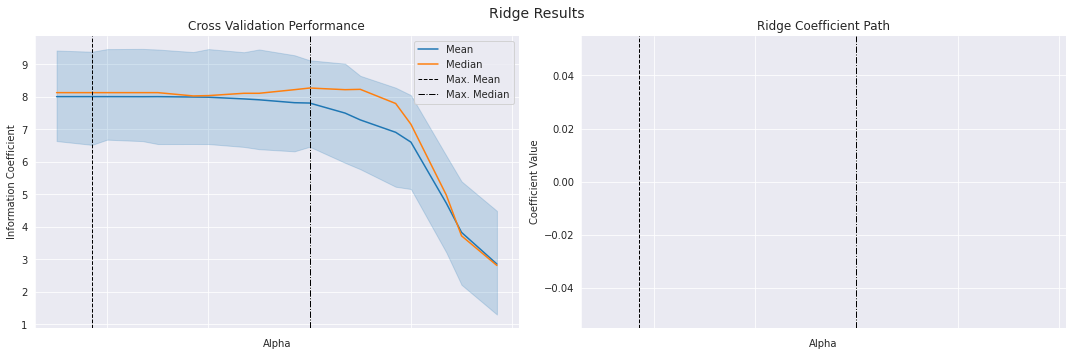

In [30]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()



ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

In [31]:
# Switch the index back to DateTimeIndex
ridge_scores.index = ridge_scores['Dates']
ridge_scores.drop(['Dates'], axis = 1,inplace=True)

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyError: 0.0005

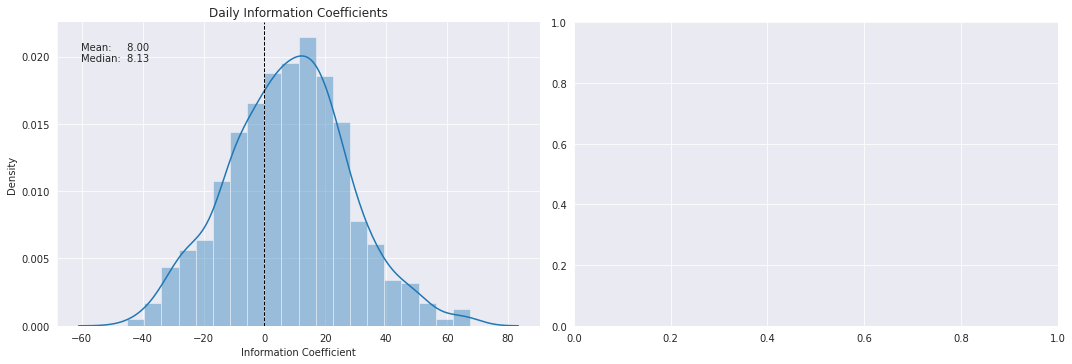

In [32]:
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha],
                     ax=axes[0])
axes[0].set_title('Daily Information Coefficients')
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')
sns.despine()
fig.tight_layout()

In [ ]:
plot_rolling_ic(ridge_scores[ridge_scores.alpha==best_alpha])

In [ ]:
ridge_scores.alpha.iloc[714:1428]

In [ ]:
# With Lasso Regression

# CV parameters
lasso_alphas = np.logspace(-10, -3, 8)

train_period_length = 30
test_period_length = 7
YEAR = 365
n_splits = int(2 * YEAR / test_period_length) # two years
lookahead = 7


In [ ]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [ ]:
# Lasso Cross-validation
target = f'target_{lookahead}d'

scaler = StandardScaler()

In [ ]:
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    
    try:
        for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
            t = time()
            X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

            pipe.fit(X=X_train, y=y_train)
            y_pred = pipe.predict(X_test)

            preds = y_test.to_frame('actuals').assign(predicted=y_pred)
            preds_by_day = preds.groupby(level='Dates')
            scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                       x.actuals)[0] * 100)
                                .to_frame('ic'),
                                preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                        y_true=x.actuals)))
                                .to_frame('rmse')],
                               axis=1)

            lasso_scores.append(scores.assign(alpha=alpha))
            lasso_predictions.append(preds.assign(alpha=alpha))

            coeffs.append(pipe.named_steps['model'].coef_)
    except IndexError: 
        print('Ran out of data for train/test splits')
        lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

In [ ]:
lasso_coeffs

In [ ]:
lasso_predictions

In [ ]:
lasso_scores

In [ ]:
# Persist Lasso outputs
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf(f'{model_dataDir}Lasso_Scores.h5', 'lasso/scores')

lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf(f'{model_dataDir}Lasso_Coeffs.h5', 'lasso/coeffs')

lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf(f'{model_dataDir}Lasso_Predictions.h5', 'lasso/predictions')



In [ ]:
# Results
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]

lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

In [ ]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

In [ ]:
# Work around for 'ValueError: cannot reindex from a duplicate axis' error in the plot below
lasso_scores['Dates'] = lasso_scores.index
len_df = lasso_scores['alpha'].count()
temp_new_index = [c for c in range(1,len_df + 1)]
lasso_scores.index = temp_new_index

In [ ]:
lasso_scores.index

In [ ]:
# Lasso Coefficient paths
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores, estimator=np.mean, label='Mean', ax=axes[0])

scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine();

In [ ]:
# Switch the index back to DateTimeIndex
lasso_scores.index = lasso_scores['Dates']
lasso_scores.drop(['Dates'], axis = 1,inplace=True)

In [ ]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout();

In [ ]:
plot_rolling_ic(lasso_scores[lasso_scores.alpha==best_alpha])

In [ ]:
# Compare results
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha==best_ridge_alpha]

In [ ]:
best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha==best_lasso_alpha]

In [ ]:
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
               best_ridge_scores.assign(Model='Ridge Regression'),
               best_lasso_scores.assign(Model='Lasso Regression')]).drop('alpha', axis=1)
df.columns = ['IC', 'RMSE', 'Model']

In [ ]:
scores = df.groupby('Model').IC.agg(['mean', 'median'])
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

scores['mean'].plot.barh(ax=axes[0], xlim=(0.85, 20), title='Mean')
scores['median'].plot.barh(ax=axes[1], xlim=(0.8, 20.1), title='Median')
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)